### Project: Analyze fluctuations in HTTP request latency data to determine reliability

- Load data (.csv) to dataframe
- Standardize and cleaning data
- Expore data
- Analyze data:
    ABC
- Apply model

In [122]:
import matplotlib.pyplot as plt
import pandas as pd
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

In [123]:
# Load dataset from CSV file
root_df = pd.read_csv('../statics/csv/raw_data.csv')

Dataset là những dữ liệu thời gian thực (time-series data) liên quan đến thông tin độ trễ (latency) từ người dùng truy cập dịch vụ.

**Details:**

*Dữ liệu là các metrics được trích xuất từ Prometheus. Metrics này liên quan đến thông tin request từ client được gửi tới Proxy. Các Exporter collect metrics từ proxy và đẩy nó về Prometheus database.* 

### Standardize and cleaning data

In [124]:
# Clean data
# Select related columns
cols = root_df.columns.to_list()
colums_drop = []
for col in cols:
    num_row = root_df.drop_duplicates(subset=col).__len__()
    if num_row == 1:
        colums_drop.append(col)
# Show columns will be drop
print("Columns will be drop: ", colums_drop)
root_df = root_df.drop(columns=colums_drop) # Only select column selected
# Rename columns
cols_rename_dict = {
    "Time": "timestamp",
    "Value #A": "value"
}
root_df = root_df.rename(columns=cols_rename_dict)
# Change datetime format for column "timestamp"
root_df['timestamp'] = pd.to_datetime(root_df["timestamp"], unit="ms")
root_df.head()

Columns will be drop:  ['__name__', 'app', 'controller_class', 'controller_namespace', 'host', 'ingress', 'job', 'kubernetes_namespace', 'namespace', 'ns', 'path', 'pod_template_hash', 'service']


,timestamp,controller_pod,instance,kubernetes_node,kubernetes_pod_name,le,method,status,value
0,2024-02-05 07:04:30,ingress-nginx-controller-browser-prod-6667d78f...,172.16.16.96:10254,br-ingress2v.itim.vn,ingress-nginx-controller-browser-prod-6667d78f...,inf,DELETE,308,13
1,2024-02-05 07:05:00,ingress-nginx-controller-browser-prod-6667d78f...,172.16.16.96:10254,br-ingress2v.itim.vn,ingress-nginx-controller-browser-prod-6667d78f...,inf,DELETE,308,13
2,2024-02-05 07:05:30,ingress-nginx-controller-browser-prod-6667d78f...,172.16.16.96:10254,br-ingress2v.itim.vn,ingress-nginx-controller-browser-prod-6667d78f...,inf,DELETE,308,13
3,2024-02-05 07:06:00,ingress-nginx-controller-browser-prod-6667d78f...,172.16.16.96:10254,br-ingress2v.itim.vn,ingress-nginx-controller-browser-prod-6667d78f...,inf,DELETE,308,13
4,2024-02-05 07:06:30,ingress-nginx-controller-browser-prod-6667d78f...,172.16.16.96:10254,br-ingress2v.itim.vn,ingress-nginx-controller-browser-prod-6667d78f...,inf,DELETE,308,13


Trên đây dataset liên quan đến thống kê truy cập từ client sau khi thông qua các bước clean và standardilize. Thông tin các cột xuất hiện trong bảng dữ liệu:
- timestamp: Dấu thời gian, biểu thị số liệu tại thời điểm đó
- le: Latency, các buckets latency (hay còn gọi là các bins theo cách gọi của histogram).
- status: HTTP status return by service
- method: HTTP method
- value: Giá trị của latency tại thời điểm timestamp, nó sẽ luôn luôn tăng (counter) vì toàn bộ số lượng request gửi tới server từ trước tới nay luôn luôn tăng chứ không giảm.

*Note*

- Dữ liệu trên được scrape từ Proxy sau mỗi 5 minutes (interval=5m) và được aggregate trong thời gian đó, vì vậy timestamp luôn luôn có delta_t = 5 minutes.
- Việc lưu thông tin về request liên quan đến latency sử dụng các buckets để thống kê giúp cho việc giảm thiểu tài nguyên lưu trữ thay vì lưu lại duration_time cho mỗi request cụ thể. Vì vậy nó giúp cho việc overview tình trạng latency service hiệu quả hơn (dễ dàng overview bằng histogram). Tuy nhiên, sẽ phải đánh đổi về độ chính xác của metrics, đặc biệt là khi có những request có latency cực cao hoặc cực thấp thì histogram sẽ không phản ánh rõ được điều đó. 

### Explore data

Đầu tiên sẽ thực hiện khám phá dataset đang xét xem có điều gì bất thường đối với tập dữ liệu đó không. Bởi dataset trên đang sử dụng cho mục đích phân tích dữ liệu liên quan đến latency của service. Nên giá trị cần lưu ý trong tập dữ liệu trên là **timestamp và value** sẽ ưu tiên để đánh giá những bất thường. 

Thực hiện vẽ biểu đồ đánh giá tổng quan theo time-series để xem xét việc tăng trưởng request đối với hệ thống

In [125]:
labels = ['controller_pod', 'instance', 'kubernetes_node', 'kubernetes_pod_name', 'le']
legends = root_df.groupby(labels).last().reset_index()[labels]
legends.head()

,controller_pod,instance,kubernetes_node,kubernetes_pod_name,le
0,ingress-nginx-controller-browser-prod-6667d78f...,172.16.16.96:10254,br-ingress2v.itim.vn,ingress-nginx-controller-browser-prod-6667d78f...,0.005
1,ingress-nginx-controller-browser-prod-6667d78f...,172.16.16.96:10254,br-ingress2v.itim.vn,ingress-nginx-controller-browser-prod-6667d78f...,0.010
2,ingress-nginx-controller-browser-prod-6667d78f...,172.16.16.96:10254,br-ingress2v.itim.vn,ingress-nginx-controller-browser-prod-6667d78f...,0.025
3,ingress-nginx-controller-browser-prod-6667d78f...,172.16.16.96:10254,br-ingress2v.itim.vn,ingress-nginx-controller-browser-prod-6667d78f...,0.050
4,ingress-nginx-controller-browser-prod-6667d78f...,172.16.16.96:10254,br-ingress2v.itim.vn,ingress-nginx-controller-browser-prod-6667d78f...,0.100


In [ ]:


#
df_group_by_le = pd.DataFrame()
for idx, row in legends.iterrows():
    controller_pod = row['controller_pod']
    instance = row['instance']
    kubernetes_node = row['kubernetes_node']
    kubernetes_pod_name = row['kubernetes_pod_name']
    le = row['le']
    df_row = root_df.query("controller_pod == @controller_pod \
                           and instance == @instance \
                           and kubernetes_node == @kubernetes_node \
                           and kubernetes_pod_name == @kubernetes_pod_name \
                           and le == @le").groupby(['timestamp'] + labels).agg({'value': 'sum'}).reset_index() # Do not care about status_code and HTTP methods
    df_group_by_le = pd.concat([df_group_by_le, df_row], ignore_index=True)
df_group_by_le.groupby(labels).plot(y="value", x="timestamp")

Vì dataset biểu thị số lượng requests theo các nhóm được tổng hợp trong các bucket latency. Vì vậy giá trị của buckets sẽ được tăng trường theo thời gian (lũy tiến) do số lượng request trong khoảng thời gian sẽ luôn tăng chứ không thể giảm.

<Axes: xlabel='timestamp,controller_pod,instance,kubernetes_node,kubernetes_pod_name,le'>

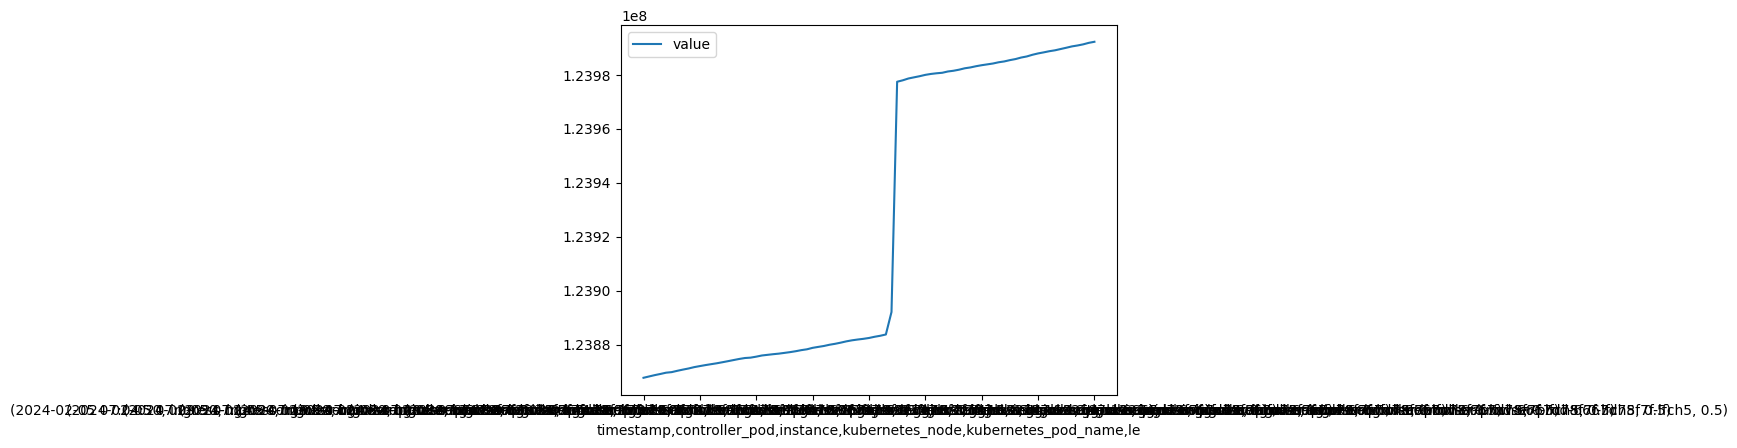

In [138]:
root_df.query("controller_pod == 'ingress-nginx-controller-browser-prod-6667d78f7f-lfch5' and instance == '172.16.16.97:10254' and kubernetes_node == 'br-ingress3v.itim.vn' and kubernetes_pod_name == 'ingress-nginx-controller-browser-prod-6667d78f7f-lfch5' and le == 0.5").groupby(['timestamp'] + labels).agg({'value': 'sum'}).plot(y="value")

Oh, có vẻ có bất thường gì đó đối với dataset. Quan sát thấy ngưỡng thời gian trong khoảng từ [7:25 -> 7:28] số lượng request tăng vọt. Vậy vấn đề ở đây là gì?